In [11]:
import requests
import pandas as pd
import datetime

In [16]:
# Replace with your actual Twelve Data API key
API_KEY = "YOUR_API_KEY"

# Instruments
symbols = ['XAU/USD', 'GBP/USD']
interval = "1h"
outputsize = 5000  # Max data points


In [13]:
def fetch_twelvedata(symbol, interval, outputsize, api_key):
    url = f"https://api.twelvedata.com/time_series"
    params = {
        "symbol": symbol,
        "interval": interval,
        "outputsize": outputsize,
        "apikey": api_key,
        "format": "JSON",
        "dp": 5
    }
    response = requests.get(url, params=params)
    data = response.json()

    if 'values' not in data:
        print(f"Error fetching {symbol}: {data.get('message', 'Unknown error')}")
        return None

    df = pd.DataFrame(data['values'])
    df['datetime'] = pd.to_datetime(df['datetime'])
    df = df.sort_values('datetime')
    df.set_index('datetime', inplace=True)
    df = df.astype(float)
    return df


In [14]:
for symbol in symbols:
    df = fetch_twelvedata(symbol, interval, outputsize, API_KEY)
    if df is not None:
        filename = symbol.replace("/", "") + "_1h.csv"
        df.to_csv(filename)
        print(f"Saved: {filename}")
    else:
        print(f"Failed to fetch: {symbol}")


Saved: XAUUSD_1h.csv
Saved: GBPUSD_1h.csv


algo

Accuracy: 0.4515
ROC AUC: 0.494

Classification report:
               precision    recall  f1-score   support

           0       0.45      0.83      0.58       453
           1       0.48      0.13      0.20       537

    accuracy                           0.45       990
   macro avg       0.46      0.48      0.39       990
weighted avg       0.46      0.45      0.38       990

Confusion matrix:
 [[377  76]
 [467  70]]


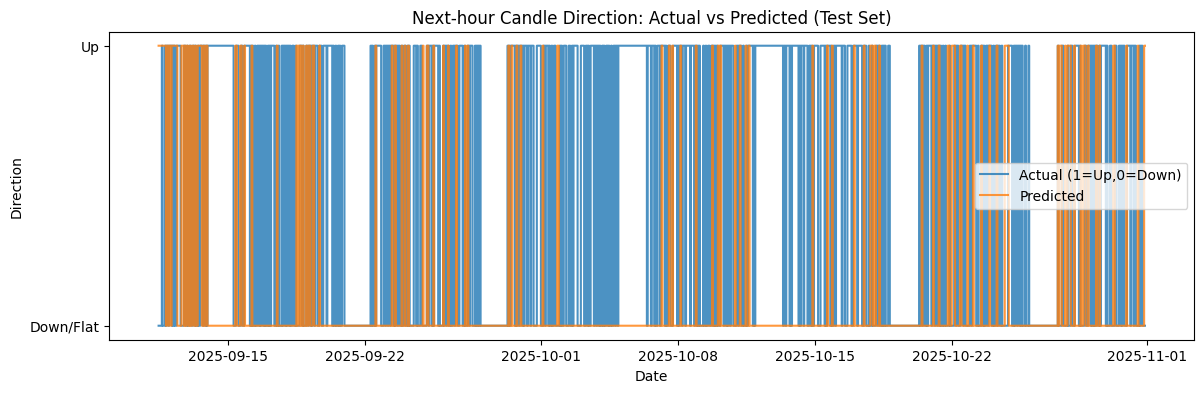

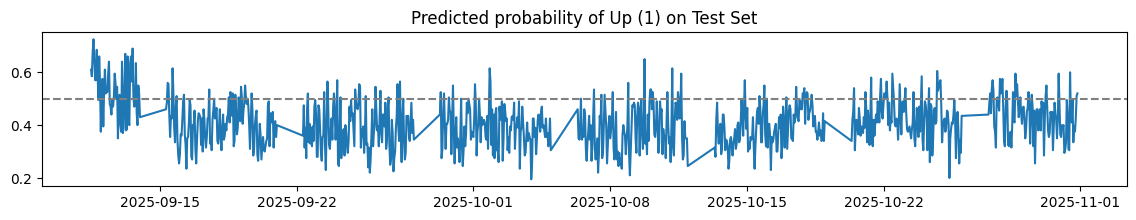

Top features:
 return            0.078593
return_lag_2      0.075759
return_lag_1      0.074927
return_lag_5      0.074273
return_lag_4      0.073812
return_lag_3      0.072845
rolling_std_10    0.071307
rolling_std_50    0.071066
RSI_14            0.071033
SMA_50            0.061088
dtype: float64

Next 1-hour candle prediction: UP (prob_up=0.520)


In [15]:
# Binary next-candle direction prediction (Up=1 / Down=0)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

# --- Load data ---
df = pd.read_csv("/content/XAUUSD_1h.csv", parse_dates=['datetime'], index_col='datetime')
df = df.sort_index()
# Ensure decimals
df = df.astype(float)

# --- Feature engineering ---
# Price returns
df['return'] = df['close'].pct_change()

# Lag features (last 1..5 returns)
for lag in range(1, 6):
    df[f'return_lag_{lag}'] = df['return'].shift(lag)

# Moving averages / volatility
df['SMA_10'] = df['close'].rolling(10).mean()
df['SMA_50'] = df['close'].rolling(50).mean()
df['rolling_std_10'] = df['close'].rolling(10).std()
df['rolling_std_50'] = df['close'].rolling(50).std()

# Simple RSI implementation
def rsi(series, period=14):
    delta = series.diff()
    up = delta.clip(lower=0)
    down = -1 * delta.clip(upper=0)
    ma_up = up.ewm(alpha=1/period, adjust=False).mean()
    ma_down = down.ewm(alpha=1/period, adjust=False).mean()
    rs = ma_up / (ma_down + 1e-12)
    return 100 - (100 / (1 + rs))

df['RSI_14'] = rsi(df['close'], 14)

# Target: whether next candle's close > current close
df['close_next'] = df['close'].shift(-1)
df['target'] = (df['close_next'] > df['close']).astype(int)  # 1=up, 0=down/flat

# Drop rows with NaN (created by indicators & shifts)
df.dropna(inplace=True)

# --- Features and target ---
feature_cols = [
    'open', 'high', 'low', 'close',
    'return', 'return_lag_1','return_lag_2','return_lag_3','return_lag_4','return_lag_5',
    'SMA_10','SMA_50','rolling_std_10','rolling_std_50','RSI_14'
]
X = df[feature_cols]
y = df['target']

# --- Train/test split (time series) ---
# Use the last 20% as test, but keep order (no shuffle)
split_idx = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

# Scale features (fit only on train)
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

# --- Train classifier ---
clf = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
clf.fit(X_train_s, y_train)

# --- Evaluate ---
y_pred = clf.predict(X_test_s)
y_proba = clf.predict_proba(X_test_s)[:, 1]

acc = accuracy_score(y_test, y_pred)
roc = roc_auc_score(y_test, y_proba)
print("Accuracy:", round(acc,4))
print("ROC AUC:", round(roc,4))
print("\nClassification report:\n", classification_report(y_test, y_pred))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))

# --- Plot predictions vs actual on test period ---
plt.figure(figsize=(14,4))
plt.plot(y_test.index, y_test.values, drawstyle='steps-post', label='Actual (1=Up,0=Down)', alpha=0.8)
plt.plot(y_test.index, y_pred, drawstyle='steps-post', label='Predicted', alpha=0.8)
plt.title("Next-hour Candle Direction: Actual vs Predicted (Test Set)")
plt.legend()
plt.xlabel("Date")
plt.ylabel("Direction")
plt.yticks([0,1], ['Down/Flat','Up'])
plt.show()

# Optional: show probability signals heatmap-ish
plt.figure(figsize=(14,2))
plt.plot(y_test.index, y_proba, label='Probability Up')
plt.axhline(0.5, color='gray', linestyle='--')
plt.title("Predicted probability of Up (1) on Test Set")
plt.show()

# --- Feature importances ---
importances = pd.Series(clf.feature_importances_, index=feature_cols).sort_values(ascending=False)
print("Top features:\n", importances.head(10))

# --- How to predict the upcoming 1-hour candle ---
last_row = X.iloc[-1:]            # last available features (most recent candle)
last_row_s = scaler.transform(last_row)
next_prob = clf.predict_proba(last_row_s)[0,1]
next_pred = clf.predict(last_row_s)[0]
print(f"\nNext 1-hour candle prediction: {'UP' if next_pred==1 else 'DOWN/FLAT'} (prob_up={next_prob:.3f})")
